In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.optimize import minimize

<h1>Mean Variance Optimization

Mean-variance optimization is a key element of data-based investing. It is the process of measuring an asset's risk against its likely return and investing based on that risk/return ratio.

<h3>1. Collect data: Gather historical data for the returns of the stocks you are interested in, as well as the risk-free rate.

In [2]:
#Asset class sample 
assets = ['Equities','Fixed Income','Real Assets','Private Equity', 'Hedge Funds']
#Asset Class details
equities = ['Vanguard Health Care ETF (VHT)',
            'S&P 500',
            'Nasdaq',
            'iShares MSCI Emerging Markets ETF',
            "VanEck Semiconductor ETF (SMH)",
            "Fidelity Blue Chip Growth Fund (FBGRX)",
            "VanEck Low Carbon Energy ETF (SMOG)",
            ]
fixedIncome = ["iShares JPMorgan USD Emerging Markets Bond ETF",
               "China 2 Years Government Bond",
               "Singapore 5 Year Government Bond",
               "US 2 Year Treasury Note",
               "Xtrackers EUR Corporate Green Bond UCITS ETF",
            ] + ['' for _ in range(2)]
realAssets = ['Gold ',
              'Vanguard Real Estate Index Fund (VNQ)',
              "Investo DB Base Metals Fund (DBB)",
            ] + ['' for _ in range(4)]
privateEquity = ['Invesco Global Listed Private Equity Portfolio (PSP)'
                ] + ['' for _ in range(6)]
hedgeFunds = [
   "Citadel flagship fund"
    ] + ['' for _ in range(6)]
data = [equities, fixedIncome, realAssets, privateEquity, hedgeFunds]

In [3]:
assetDetails = {}
for i in range(len(assets)):
    assetDetails[assets[i]] = data[i]

In [4]:
AssetAllocation = pd.DataFrame(assetDetails)
AssetAllocation

,Equities,Fixed Income,Real Assets,Private Equity,Hedge Funds
0,Vanguard Health Care ETF (VHT),iShares JPMorgan USD Emerging Markets Bond ETF,Gold,Invesco Global Listed Private Equity Portfolio...,Citadel flagship fund
1,S&P 500,China 2 Years Government Bond,Vanguard Real Estate Index Fund (VNQ),,
2,Nasdaq,Singapore 5 Year Government Bond,Investo DB Base Metals Fund (DBB),,
3,iShares MSCI Emerging Markets ETF,US 2 Year Treasury Note,,,
4,VanEck Semiconductor ETF (SMH),Xtrackers EUR Corporate Green Bond UCITS ETF,,,
5,Fidelity Blue Chip Growth Fund (FBGRX),,,,
6,VanEck Low Carbon Energy ETF (SMOG),,,,


In [5]:
# Past performance for equities 
#(2002-2022)
snp500 = [-21.97,28.36,10.74,4.83,15.61,5.48,-36.55,25.94,14.82,2.10,15.89,32.15,13.52,1.38,11.77,21.61,-4.23,31.21,18.02,28.47,-18.0]
nasdaq = [-31.53,50.01,8.59,1.37,9.52,9.81,-40.54,43.89,16.91,-1.80,15.91,38.32,13.40,5.73,7.50,28.24,-3.88,35.23,43.64,21.39,-33.10]
#2008-2022
vht = [-23.33,21.9,5.8,10.55,19.08,42.66,25.41,7.18,-3.32,23.35,5.49,22,18.34,20.41,-5.55]
#2009-2022
msci_emerging_market = [78.51,18.88,-18.42,18.22,-2.60,-2.19,-14.92,11.19,37.28,-14.57,18.42,18.31,-2.54,-20.09]
#2013-2022
#VanEck Semiconductor ETF (SMH) -> semiconductor etf
smh = [33.71,29.99,-0.11,35.41,38.31,-8.95,64.49,55.31,42.24,-33.48]
#Fidelity Blue Chip Growth Fund (FBGRX) 
fbgrx = [39.84,14.60,6.28,1.59,36.06,1.07,33.44,62.23,22.71,-38.46]
#VanEck Low Carbon Energy ETF (SMOG)
smog = [69.72,-3.04,1.45,-5.25,21.89,-9.02,37.39,118.63,-3.00,-29.54]

#Past performance Real Asset 
#Invesco DB Base Metals Fund (DBB) 2013-2022
dbb = [-12.31,-4.70,-25.75,25.95,29.65,-19.13,-1.12,14.78,28.67,-11.09]
#gold price 2013-2022
gold = [-13.5,3.3,9.7,15.4,-8.4,4.6,18.9,28.5,-3.6,0.4]
# 'Vanguard Real Estate Index Fund (VNQ)'
vnq= [2.34,30.41,2.4,8.53,4.9,-5.97,28.89,-4.64,40.33,-26.21]

#past performance fix income 
emb = [-7.42,6.69,0.43,9.41,9.98,-5.67,15.57,5.48,-2.45,-18.03]
china_2ybond = [2.341,2.325,2.473,2.798,3.824,2.897,2.668,2.740,2.349,2.294]
sg_5ybond = [2.23,2.12,2,1.858,1.689,1.904,1.555,0.453,1.351,2.839]
us_2ytreasury = [0.36,0.42,0.64,0.72,1.39,2.27,1.75,0.25,0.25,2.34]


In [6]:
assetDf = pd.DataFrame(
    {
        #equities
        "S&P 500":[x/100 for x in snp500][11::],
        "Nasdaq":[x/100 for x in nasdaq][11::],
        "VHT":[x/100 for x in vht][5::],
        "iShares MSCI Emerging Markets ETF": [x/100 for x in msci_emerging_market][4::],
        "VanEck Semiconductor ETF (SMH)": [x/100 for x in smh],
        "Fidelity Blue Chip Growth Fund (FBGRX)":[x/100 for x in fbgrx],
        "VanEck Low Carbon Energy ETF (SMOG)":[x/100 for x in smog],
        # real asset 
        "Invesco DB Base Metals Fund (DBB)": [x/100 for x in dbb],
        "gold":[x/100 for x in gold],
        'Vanguard Real Estate Index Fund (VNQ)':[x/100 for x in vnq],
        # Fix Income 
        'iShares JPMorgan USD Emerging Markets Bond ETF (EMB)':[x/100 for x in emb],
         "China 2 Years Government Bond":[x/100 for x in china_2ybond],
        "Singapore 5 Year Government Bond":[x/100 for x in sg_5ybond],
        "US 2 Year Treasury Note":[x/100 for x in us_2ytreasury],
        #"Xtrackers EUR Corporate Green Bond UCITS ETF":[] -> assume 2.5%,    
    }
)
assetDf

,S&P 500,Nasdaq,VHT,iShares MSCI Emerging Markets ETF,VanEck Semiconductor ETF (SMH),Fidelity Blue Chip Growth Fund (FBGRX),VanEck Low Carbon Energy ETF (SMOG),Invesco DB Base Metals Fund (DBB),gold,Vanguard Real Estate Index Fund (VNQ),iShares JPMorgan USD Emerging Markets Bond ETF (EMB),China 2 Years Government Bond,Singapore 5 Year Government Bond,US 2 Year Treasury Note
0,0.3215,0.3832,0.4266,-0.0260,0.3371,0.3984,0.6972,-0.1231,-0.135,0.0234,-0.0742,0.02341,0.02230,0.0036
1,0.1352,0.1340,0.2541,-0.0219,0.2999,0.1460,-0.0304,-0.0470,0.033,0.3041,0.0669,0.02325,0.02120,0.0042
2,0.0138,0.0573,0.0718,-0.1492,-0.0011,0.0628,0.0145,-0.2575,0.097,0.0240,0.0043,0.02473,0.02000,0.0064
3,0.1177,0.0750,-0.0332,0.1119,0.3541,0.0159,-0.0525,0.2595,0.154,0.0853,0.0941,0.02798,0.01858,0.0072
4,0.2161,0.2824,0.2335,0.3728,0.3831,0.3606,0.2189,0.2965,-0.084,0.0490,0.0998,0.03824,0.01689,0.0139
5,-0.0423,-0.0388,0.0549,-0.1457,-0.0895,0.0107,-0.0902,-0.1913,0.046,-0.0597,-0.0567,0.02897,0.01904,0.0227
6,0.3121,0.3523,0.2200,0.1842,0.6449,0.3344,0.3739,-0.0112,0.189,0.2889,0.1557,0.02668,0.01555,0.0175
7,0.1802,0.4364,0.1834,0.1831,0.5531,0.6223,1.1863,0.1478,0.285,-0.0464,0.0548,0.02740,0.00453,0.0025
8,0.2847,0.2139,0.2041,-0.0254,0.4224,0.2271,-0.0300,0.2867,-0.036,0.4033,-0.0245,0.02349,0.01351,0.0025
9,-0.1800,-0.3310,-0.0555,-0.2009,-0.3348,-0.3846,-0.2954,-0.1109,0.004,-0.2621,-0.1803,0.02294,0.02839,0.0234


In [7]:
equitiesDf = assetDf[[
    "S&P 500",
    "Nasdaq",
    "VHT",
    "iShares MSCI Emerging Markets ETF",
    "VanEck Semiconductor ETF (SMH)",
    "Fidelity Blue Chip Growth Fund (FBGRX)",
    "VanEck Low Carbon Energy ETF (SMOG)"]]
equitiesDf

,S&P 500,Nasdaq,VHT,iShares MSCI Emerging Markets ETF,VanEck Semiconductor ETF (SMH),Fidelity Blue Chip Growth Fund (FBGRX),VanEck Low Carbon Energy ETF (SMOG)
0,0.3215,0.3832,0.4266,-0.0260,0.3371,0.3984,0.6972
1,0.1352,0.1340,0.2541,-0.0219,0.2999,0.1460,-0.0304
2,0.0138,0.0573,0.0718,-0.1492,-0.0011,0.0628,0.0145
3,0.1177,0.0750,-0.0332,0.1119,0.3541,0.0159,-0.0525
4,0.2161,0.2824,0.2335,0.3728,0.3831,0.3606,0.2189
5,-0.0423,-0.0388,0.0549,-0.1457,-0.0895,0.0107,-0.0902
6,0.3121,0.3523,0.2200,0.1842,0.6449,0.3344,0.3739
7,0.1802,0.4364,0.1834,0.1831,0.5531,0.6223,1.1863
8,0.2847,0.2139,0.2041,-0.0254,0.4224,0.2271,-0.0300
9,-0.1800,-0.3310,-0.0555,-0.2009,-0.3348,-0.3846,-0.2954


In [8]:
realAssetDf = assetDf[[
    "Invesco DB Base Metals Fund (DBB)",
    "gold",
    "Vanguard Real Estate Index Fund (VNQ)"]]
realAssetDf

,Invesco DB Base Metals Fund (DBB),gold,Vanguard Real Estate Index Fund (VNQ)
0,-0.1231,-0.135,0.0234
1,-0.0470,0.033,0.3041
2,-0.2575,0.097,0.0240
3,0.2595,0.154,0.0853
4,0.2965,-0.084,0.0490
5,-0.1913,0.046,-0.0597
6,-0.0112,0.189,0.2889
7,0.1478,0.285,-0.0464
8,0.2867,-0.036,0.4033
9,-0.1109,0.004,-0.2621


In [9]:
ficDf = assetDf[[
    "iShares JPMorgan USD Emerging Markets Bond ETF (EMB)",
    "China 2 Years Government Bond",
    "Singapore 5 Year Government Bond",
    "US 2 Year Treasury Note"
]]
ficDf

,iShares JPMorgan USD Emerging Markets Bond ETF (EMB),China 2 Years Government Bond,Singapore 5 Year Government Bond,US 2 Year Treasury Note
0,-0.0742,0.02341,0.02230,0.0036
1,0.0669,0.02325,0.02120,0.0042
2,0.0043,0.02473,0.02000,0.0064
3,0.0941,0.02798,0.01858,0.0072
4,0.0998,0.03824,0.01689,0.0139
5,-0.0567,0.02897,0.01904,0.0227
6,0.1557,0.02668,0.01555,0.0175
7,0.0548,0.02740,0.00453,0.0025
8,-0.0245,0.02349,0.01351,0.0025
9,-0.1803,0.02294,0.02839,0.0234


<h3>2. Calculate expected returns: Calculate the expected return for each stock based on historical data, using techniques such as historical mean or a forecasted estimate.

In [10]:
assetPerformance = pd.DataFrame(
    {
        "Asset Name": [
            #equities
            "S&P 500",#
            "Nasdaq",#
            "VHT",#
            "iShares MSCI Emerging Markets ETF",#
            "VanEck Semiconductor ETF (SMH)",#
            "Fidelity Blue Chip Growth Fund (FBGRX)",#
            "VanEck Low Carbon Energy ETF (SMOG)",#
            #Real asset
            "Invesco DB Base Metals Fund (DBB)",#
            "gold",#
            'Vanguard Real Estate Index Fund (VNQ)',#
            #Fix income
            'iShares JPMorgan USD Emerging Markets Bond ETF (EMB)',
             "China 2 Years Government Bond",#
            "Singapore 5 Year Government Bond",#
            "US 2 Year Treasury Note",
            ],
        "Long Term Forecast Annual Return (%)":[
            6.75,
            9.29,
            8.74,
            6.13,
            11.2,
            10.07,
            5.47,
            9.52,
            4.36,
            7.12,
            4.58,
            2.808,
            2.38,
            3.438,            
        ]
    }
)
assetPerformance

,Asset Name,Long Term Forecast Annual Return (%)
0,S&P 500,6.750
1,Nasdaq,9.290
2,VHT,8.740
3,iShares MSCI Emerging Markets ETF,6.130
4,VanEck Semiconductor ETF (SMH),11.200
5,Fidelity Blue Chip Growth Fund (FBGRX),10.070
6,VanEck Low Carbon Energy ETF (SMOG),5.470
7,Invesco DB Base Metals Fund (DBB),9.520
8,gold,4.360
9,Vanguard Real Estate Index Fund (VNQ),7.120


In [11]:
citadel_hf = np.array([x/100 for x in [10,20,22,20,18,16,6,12,10,16,22]])
print(citadel_hf.std()) #0.0517 risk
print(citadel_hf.mean()) #0.156 annual return

#PE (PSP) long term return : 9.44%, risk 11.04

0.05174636171184621
0.15636363636363637


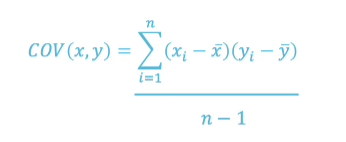

In [12]:
assetCov=assetDf.cov()
assetCov

,S&P 500,Nasdaq,VHT,iShares MSCI Emerging Markets ETF,VanEck Semiconductor ETF (SMH),Fidelity Blue Chip Growth Fund (FBGRX),VanEck Low Carbon Energy ETF (SMOG),Invesco DB Base Metals Fund (DBB),gold,Vanguard Real Estate Index Fund (VNQ),iShares JPMorgan USD Emerging Markets Bond ETF (EMB),China 2 Years Government Bond,Singapore 5 Year Government Bond,US 2 Year Treasury Note
S&P 500,0.026980,0.034448,0.019397,0.018609,0.045497,0.037186,0.041058,0.016005,-0.001706,0.022875,0.009469,0.000096,-0.000524,-0.000778
Nasdaq,0.034448,0.053334,0.026498,0.028831,0.063917,0.062562,0.083817,0.017993,0.004411,0.022387,0.014393,0.000253,-0.001029,-0.001146
VHT,0.019397,0.026498,0.021539,0.009324,0.026679,0.030163,0.037556,0.001952,-0.007157,0.013324,0.003357,0.000002,-0.000215,-0.000597
iShares MSCI Emerging Markets ETF,0.018609,0.028831,0.009324,0.032956,0.042692,0.034225,0.039898,0.027004,0.004333,0.009987,0.014158,0.000614,-0.000652,-0.000276
VanEck Semiconductor ETF (SMH),0.045497,0.063917,0.026679,0.042692,0.092888,0.071618,0.085653,0.037327,0.011490,0.040453,0.024052,0.000309,-0.001368,-0.001388
Fidelity Blue Chip Growth Fund (FBGRX),0.037186,0.062562,0.030163,0.034225,0.071618,0.076806,0.107122,0.020907,0.006826,0.020944,0.015801,0.000378,-0.001366,-0.001316
VanEck Low Carbon Energy ETF (SMOG),0.041058,0.083817,0.037556,0.039898,0.085653,0.107122,0.198264,0.014000,0.019350,-0.002665,0.013074,0.000228,-0.001918,-0.001676
Invesco DB Base Metals Fund (DBB),0.016005,0.017993,0.001952,0.027004,0.037327,0.020907,0.014000,0.042862,0.001310,0.015458,0.009508,0.000444,-0.000664,-0.000549
gold,-0.001706,0.004411,-0.007157,0.004333,0.011490,0.006826,0.019350,0.001310,0.016588,-0.000388,0.005957,-0.000026,-0.000461,-0.000051
Vanguard Real Estate Index Fund (VNQ),0.022875,0.022387,0.013324,0.009987,0.040453,0.020944,-0.002665,0.015458,-0.000388,0.039803,0.011500,-0.000110,-0.000396,-0.000794


In [13]:
eqCov = equitiesDf.cov()
eqCov

,S&P 500,Nasdaq,VHT,iShares MSCI Emerging Markets ETF,VanEck Semiconductor ETF (SMH),Fidelity Blue Chip Growth Fund (FBGRX),VanEck Low Carbon Energy ETF (SMOG)
S&P 500,0.026980,0.034448,0.019397,0.018609,0.045497,0.037186,0.041058
Nasdaq,0.034448,0.053334,0.026498,0.028831,0.063917,0.062562,0.083817
VHT,0.019397,0.026498,0.021539,0.009324,0.026679,0.030163,0.037556
iShares MSCI Emerging Markets ETF,0.018609,0.028831,0.009324,0.032956,0.042692,0.034225,0.039898
VanEck Semiconductor ETF (SMH),0.045497,0.063917,0.026679,0.042692,0.092888,0.071618,0.085653
Fidelity Blue Chip Growth Fund (FBGRX),0.037186,0.062562,0.030163,0.034225,0.071618,0.076806,0.107122
VanEck Low Carbon Energy ETF (SMOG),0.041058,0.083817,0.037556,0.039898,0.085653,0.107122,0.198264


In [14]:
raCov = realAssetDf.cov()
raCov

,Invesco DB Base Metals Fund (DBB),gold,Vanguard Real Estate Index Fund (VNQ)
Invesco DB Base Metals Fund (DBB),0.042862,0.001310,0.015458
gold,0.001310,0.016588,-0.000388
Vanguard Real Estate Index Fund (VNQ),0.015458,-0.000388,0.039803


In [15]:
ficCov = ficDf.cov()
ficCov

,iShares JPMorgan USD Emerging Markets Bond ETF (EMB),China 2 Years Government Bond,Singapore 5 Year Government Bond,US 2 Year Treasury Note
iShares JPMorgan USD Emerging Markets Bond ETF (EMB),0.010047,0.000215,-0.000344,-0.000228
China 2 Years Government Bond,0.000215,0.000021,-0.000008,0.000010
Singapore 5 Year Government Bond,-0.000344,-0.000008,0.000039,0.000023
US 2 Year Treasury Note,-0.000228,0.000010,0.000023,0.000069


In [16]:
def procCov(covDf, assetNames):
    proc = []
    for index,row in covDf.iterrows():
        crow = []
        for assetName in assetNames:
            crow.append(row[assetName])
        proc.append(crow)

In [17]:
procAssetCov = np.array(procCov(assetCov,assetPerformance["Asset Name"]))
procEqCov = np.array(procCov(eqCov,assetPerformance["Asset Name"][0:7]))
procRaCov = np.array(procCov(raCov,assetPerformance["Asset Name"][7:10]))
procFicCov = np.array(procCov(ficCov,assetPerformance["Asset Name"][10:14]))

In [18]:
assetReturn = np.array([asset/100 for asset in assetPerformance["Long Term Forecast Annual Return (%)"]])
eqReturn = np.array([asset/100 for asset in assetPerformance["Long Term Forecast Annual Return (%)"][0:7]])
raReturn = np.array([asset/100 for asset in assetPerformance["Long Term Forecast Annual Return (%)"][7:10]])
ficReturn = np.array([asset/100 for asset in assetPerformance["Long Term Forecast Annual Return (%)"][10:14]])

In [19]:
# Define the objective function
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Define the constraint functions
def weight_sum_constraint(weights):
    return np.sum(weights) - 1

# Define the optimization function
def optimize_portfolio(expected_returns, cov_matrix):
    n_assets = len(expected_returns)
    initial_weights = np.ones(n_assets) / n_assets
    bounds = ((0, 1),) * n_assets
    constraints = [{'type': 'eq', 'fun': weight_sum_constraint}]
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', constraints=constraints, bounds=bounds)
    return result

def sharpe_ratio(profit ,risk):
    #assume risk free rate of US (LTCMA) = 3.2%
    return (profit-0.032)/risk

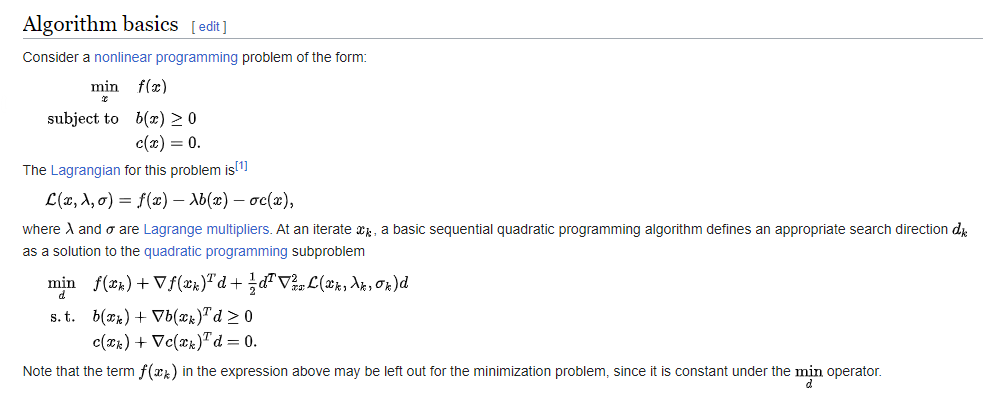

strategy: Fix ratio for hedge fund and 1 mil reserve cash. (20% hedge fund)

Computed Weightage

In [20]:
# Call the optimization function and print the results
result = optimize_portfolio(assetReturn, assetCov)
optimal_Weights = result.x
optimal_Return = np.dot(optimal_Weights, assetReturn)
optimal_Risk = np.sqrt(portfolio_variance(optimal_Weights, assetCov))
print("Optimal Assets Weights")
for assetName, eqWeight in zip(assetPerformance["Asset Name"],optimal_Weights):  
    print(assetName,'=',eqWeight)
print("")
print("Optimal Equities return:", str(optimal_Return*100)+"%")
print("Optimal Equities risk:", str(optimal_Risk*100)+"%")
print("Optimal Equities sharpe ratio",sharpe_ratio(optimal_Return,optimal_Risk))

Optimal Assets Weights
S&P 500 = 0.0
Nasdaq = 2.893135674023271e-19
VHT = 0.024808935593281147
iShares MSCI Emerging Markets ETF = 0.0
VanEck Semiconductor ETF (SMH) = 0.0
Fidelity Blue Chip Growth Fund (FBGRX) = 9.33022580482907e-19
VanEck Low Carbon Energy ETF (SMOG) = 0.0
Invesco DB Base Metals Fund (DBB) = 0.003363037467816848
gold = 0.014926727749353044
Vanguard Real Estate Index Fund (VNQ) = 0.00011602265754558349
iShares JPMorgan USD Emerging Markets Bond ETF (EMB) = 1.306503594560349e-19
China 2 Years Government Bond = 0.30373937419669716
Singapore 5 Year Government Bond = 0.3293861417697291
US 2 Year Treasury Note = 0.3236597605655772

Optimal Equities return: 3.0643342650685326%
Optimal Equities risk: 0.33362288746846036%
Optimal Equities sharpe ratio -0.4066439684666206


In [21]:
all_return = []
all_risk = []

Computed Weightage

In [22]:
eqresult = optimize_portfolio(eqReturn, eqCov)
optimal_eqWeights = eqresult.x
optimal_eqReturn = np.dot(optimal_eqWeights, eqReturn)
optimal_eqRisk = np.sqrt(portfolio_variance(optimal_eqWeights, eqCov))
print("Optimal Equities Weights")
for assetName, eqWeight in zip(assetPerformance["Asset Name"][0:7],optimal_eqWeights):  
    print(assetName,'=',eqWeight)
print("")
print("Optimal Equities return:", str(optimal_eqReturn*100)+"%")
print("Optimal Equities risk:", str(optimal_eqRisk*100)+"%")
print("Optimal Equities sharpe ratio",sharpe_ratio(optimal_eqReturn,optimal_eqRisk))

Optimal Equities Weights
S&P 500 = 0.0
Nasdaq = 2.0321377601792305e-16
VHT = 0.6592359424854183
iShares MSCI Emerging Markets ETF = 0.3407640575145818
VanEck Semiconductor ETF (SMH) = 0.0
Fidelity Blue Chip Growth Fund (FBGRX) = 2.0728059347314505e-17
VanEck Low Carbon Energy ETF (SMOG) = 0.0

Optimal Equities return: 7.850605809886946%
Optimal Equities risk: 13.182059598852792%
Optimal Equities sharpe ratio 0.3527981173967442


Fine Tune

In [23]:
tune_eqWeights = np.array([0.1,0.15,0.3,0.2,0.1,0.1,0.05])
tune_eqReturn = np.dot(tune_eqWeights,eqReturn)
tune_eqRisk = np.sqrt(portfolio_variance(tune_eqWeights, eqCov))
print("")
print("Tuned Equities return:", str(tune_eqReturn*100)+"%")
print("Tuned Equities risk:", str(tune_eqRisk*100)+"%")
print("Tuned Equities sharpe ratio",sharpe_ratio(tune_eqReturn,tune_eqRisk))
all_return.append(tune_eqReturn)
all_risk.append(tune_eqRisk)


Tuned Equities return: 8.317%
Tuned Equities risk: 18.434230218988443%
Tuned Equities sharpe ratio 0.27758143080632464


In [24]:
raresult = optimize_portfolio(raReturn, raCov)
optimal_raWeights = raresult.x
optimal_raReturn = np.dot(optimal_raWeights, raReturn)
optimal_raRisk = np.sqrt(portfolio_variance(optimal_raWeights, raCov))
print("Optimal Real Assets Weights")
for assetName, raWeight in zip(assetPerformance["Asset Name"][7:10],optimal_raWeights):  
    print(assetName,'=',raWeight)
print("")
print("Optimal Real Assets return:", str(optimal_raReturn*100)+"%")
print("Optimal Real Assets risk:", str(optimal_raRisk*100)+"%")
print("Optimal Real Assets sharpe ratio",sharpe_ratio(optimal_raReturn,optimal_raRisk))
all_return.append(optimal_raReturn)
all_risk.append(optimal_raRisk)

Optimal Real Assets Weights
Invesco DB Base Metals Fund (DBB) = 0.1552230363904289
gold = 0.6345387869884129
Vanguard Real Estate Index Fund (VNQ) = 0.2102381766211583

Optimal Real Assets return: 5.74120823524901%
Optimal Real Assets risk: 10.31227903837975%
Optimal Real Assets sharpe ratio 0.24642547256443145


In [25]:
ficresult = optimize_portfolio(ficReturn, ficCov)
optimal_ficWeights = ficresult.x
optimal_ficReturn = np.dot(optimal_ficWeights, ficReturn)
optimal_ficRisk = np.sqrt(portfolio_variance(optimal_ficWeights, ficCov))
print("Optimal Fix Income Weights")
for assetName, ficWeight in zip(assetPerformance["Asset Name"][10:14],optimal_ficWeights):  
    print(assetName,'=',ficWeight)
print("")
print("Optimal Fix Income return:", str(optimal_ficReturn*100)+"%")
print("Optimal Fix Income risk:", str(optimal_ficRisk*100)+"%")
print("Optimal Fix Income sharpe ratio",sharpe_ratio(optimal_ficReturn,optimal_ficRisk))

Optimal Fix Income Weights
iShares JPMorgan USD Emerging Markets Bond ETF (EMB) = 0.013993333993310125
China 2 Years Government Bond = 0.31911326810990537
Singapore 5 Year Government Bond = 0.3361309391846768
US 2 Year Treasury Note = 0.33076245871210774

Optimal Fix Income return: 2.897312494853731%
Optimal Fix Income risk: 0.42557220018061237%
Optimal Fix Income sharpe ratio -0.7112483029150128


In [26]:
#bond redistriubtion with green bond (projection)
tune_ficWeights = np.array([0.05,0.29,0.31,0.3])
tune_ficReturn = np.dot(tune_ficWeights,ficReturn)
tune_ficRisk = np.sqrt(portfolio_variance(tune_ficWeights,ficCov))
print("")
#2.84, 3.2
tune_ficReturn = 0.95 * tune_ficReturn + 0.05*0.0284
tune_ficRisk = 0.95 * tune_ficRisk + 0.05*0.022
print("Tuned fix income return:", str(tune_ficReturn*100)+"%")
print("Tuned fix income risk:", str(tune_ficRisk*100)+"%")
print("Tuned fix income sharpe ratio",sharpe_ratio(tune_ficReturn,tune_ficRisk))
all_return.append(tune_ficReturn)
all_risk.append(tune_ficRisk)


Tuned fix income return: 2.813894%
Tuned fix income risk: 0.6315284481096566%
Tuned fix income sharpe ratio -0.6113833844789175


In [30]:
def getTotal(assetReturn,assetRisk,ratioList,phase):
    print("### PHASE :",phase,"###")
    total_return = 0
    total_risk = 0
    for ret,risk,ratio in zip(assetReturn,assetRisk,ratioList):
        total_return += ratio*ret
        total_risk += ratio*risk
    print("Total Annual Return: ", str(total_return*100)+"%")
    print("Total Risk: ",str(total_risk*100)+"%")
    print("Total sharpe ratio: ", sharpe_ratio(total_return,total_risk))

In [28]:
#add hf and pe

all_return += [0.0944, 0.156]
all_risk += [0.114,0.0517]

In [45]:
#order -> eq, ra, fic, pe, hf
phase1 = [0.3,0.05,0.05,0.25,0.35]
getTotal(all_return, all_risk,phase1,1)

### PHASE : 1 ###
Total Annual Return:  10.74285511176245%
Total Risk:  10.736959440021003%
Total sharpe ratio:  0.70251314200249


In [51]:
phase2 = [0.3,0.1,0.15,0.15,0.30]
getTotal(all_return, all_risk,phase2,2)

### PHASE : 2 ###
Total Annual Return:  9.5873049235249%
Total Risk:  9.917226236750954%
Total sharpe ratio:  0.644061632864139


In [41]:
phase3 = [0.35,0.1,0.2,0.1,0.2]
getTotal(all_return, all_risk,phase3,3)

### PHASE : 3 ###
Total Annual Return:  8.1118496235249%
Total Risk:  9.783514170105862%
Total sharpe ratio:  0.5020537138417364
